In [1]:
##Khai báo các thư viện
from __future__ import print_function
import time
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, BatchNormalization,GRU
from keras.datasets import imdb

import os
from keras.preprocessing.text import Tokenizer


Using Theano backend.


In [2]:
## Gán nhãn cho dữ liệu train
X_train = []
y_train = []

path = 'C:/KHOALUAN/DATA/individual_stocs_reuter/walmart/train/pos/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])

y_train.extend([1 for _ in range(880)])

path = 'C:/KHOALUAN/DATA/individual_stocs_reuter/walmart/train/neg/'
X_train.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])

y_train.extend([0 for _ in range(604)])


In [3]:
##Gán nhãn cho dữ liệu test
X_test = []
y_test = []

path = 'C:/KHOALUAN/DATA/individual_stocs_reuter/walmart/test/pos/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([1 for _ in range(439)])

path = 'C:/KHOALUAN/DATA/individual_stocs_reuter/walmart/test/neg/'
X_test.extend([open(path + f).read() for f in os.listdir(path) if f.endswith('.txt')])
y_test.extend([0 for _ in range(302)])


In [4]:
## Khai báo tham số đặc trưng và chiều dài câu
max_features =1000
max_len = 500  # cut texts after this number of words (among top max_features most common words)

In [5]:
## Xử lý remove stop words cho dữ liệu train
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

X_train_rm= []
stop_words=set(stopwords.words("english"))
for x in X_train:
    words=word_tokenize(x)
    remove_sw= [w for w in words if not w in stop_words]
    X_train_rm.append(remove_sw),
sentence_train=[] 
for i in range(len(X_train_rm)):
    s = ""
    for j in range(len(X_train_rm[i])):
        s+=X_train_rm[i][j]+" "
    sentence_train.append(s),


In [6]:
## Xử lý remove stop words cho dữ liệu test
X_test_rm= []
stop_words=set(stopwords.words("english"))
for x in X_test:
    words=word_tokenize(x)
    remove_sw= [w for w in words if not w in stop_words]

    X_test_rm.append(remove_sw),
sentence_test=[] 
for i in range(len(X_test_rm)):
    s = ""
    for j in range(len(X_test_rm[i])):
        s+=X_test_rm[i][j]+" "
    sentence_test.append(s),


In [7]:
print("Number of words: ")
print(len(np.unique(np.hstack(X_train ))))

Number of words: 
1401


Review length: 
Mean 1562.93 words (675.128891)


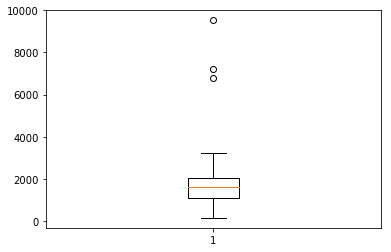

In [8]:
from matplotlib import pyplot
# Summarize review length
print("Review length: ")
result = map(len, X_train)
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

In [9]:
# Xứ lý tách từ 
imdbTokenizer = Tokenizer(nb_words=max_features)

imdbTokenizer.fit_on_texts(sentence_train)
#for word, value in imdbTokenizer.word_index.items():
    #print(word),


In [10]:
#create int to word dictionary
intToWord = {}
for word, value in imdbTokenizer.word_index.items():
    intToWord[value] = word

#add a symbol for null placeholder
intToWord[0] = "!!!NA!!!"
    
print(intToWord[1])
print(intToWord[2])
print(intToWord[32])


walmart
said
fell


In [11]:
#convert word strings to integer sequence lists
#print(X_train[0])
#print(imdbTokenizer.texts_to_sequences(X_train[:1]))
#for value in imdbTokenizer.texts_to_sequences(X_train[:1])[0]:
    #print(intToWord[value])
    
X_train = imdbTokenizer.texts_to_sequences(sentence_train)
X_test = imdbTokenizer.texts_to_sequences(sentence_test)


In [12]:
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)


1484 train sequences
741 test sequences
Pad sequences (samples x time)
X_train shape: (1484L, 500L)
X_test shape: (741L, 500L)


In [13]:
epochs = 40
embedding_neurons = 128
lstm_neurons = 64
batch_size =32


In [14]:
# Bi-directional Atom

# based on keras tutorial: https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4)(bnorm)
# apply backwards LSTM
backwards = GRU(lstm_neurons, dropout_W=0.4, dropout_U=0.4, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0.5)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_atom = Model(input=sequence, output=output)
# review model structure
print(model_bidir_atom.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 500, 128)      128000      input_1[0][0]                    
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 500, 128)      512         embedding_1[0][0]                
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 64)            37056       batchnormalization_1[0][0]       
___________________________________________________________________________________________

In [15]:
# Bi-directional Atom

# try using different optimizers and different optimizer configs
model_bidir_atom.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_atom = model_bidir_atom.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)




Train...
Train on 1484 samples, validate on 741 samples
Epoch 1/40
126s - loss: 0.7521 - acc: 0.5613 - val_loss: 0.6943 - val_acc: 0.4561
Epoch 2/40
154s - loss: 0.7093 - acc: 0.5748 - val_loss: 0.6783 - val_acc: 0.5924
Epoch 3/40
151s - loss: 0.6860 - acc: 0.5997 - val_loss: 0.6930 - val_acc: 0.5169
Epoch 4/40
147s - loss: 0.6677 - acc: 0.6166 - val_loss: 0.6800 - val_acc: 0.5938
Epoch 5/40
137s - loss: 0.6358 - acc: 0.6476 - val_loss: 0.6779 - val_acc: 0.5951
Epoch 6/40
137s - loss: 0.6121 - acc: 0.6557 - val_loss: 0.6771 - val_acc: 0.5924
Epoch 7/40
150s - loss: 0.5793 - acc: 0.7008 - val_loss: 0.6874 - val_acc: 0.5924
Epoch 8/40
146s - loss: 0.5270 - acc: 0.7385 - val_loss: 0.7373 - val_acc: 0.5843
Epoch 9/40
140s - loss: 0.4997 - acc: 0.7601 - val_loss: 0.8539 - val_acc: 0.5830
Epoch 10/40
139s - loss: 0.4722 - acc: 0.7823 - val_loss: 0.9145 - val_acc: 0.5709
Epoch 11/40
142s - loss: 0.4518 - acc: 0.8019 - val_loss: 1.0204 - val_acc: 0.5655
Epoch 12/40
146s - loss: 0.4205 - acc: 0

NameError: name 'model_fdir_atom' is not defined

In [17]:
scores = model_bidir_atom.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

import matplotlib.pyplot as plt
print(history_bidir_atom.history.keys())

Accuracy: 53.31%
['acc', 'loss', 'val_acc', 'val_loss']


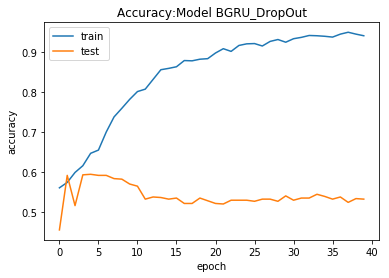

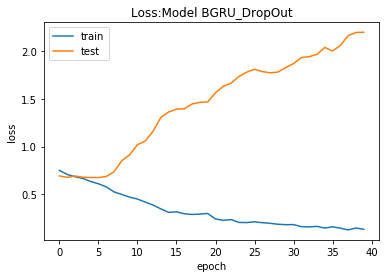

In [27]:
# summarize history for accuracy
plt.plot(history_bidir_atom.history['acc'])
plt.plot(history_bidir_atom.history['val_acc'])
plt.title('Accuracy:Model BGRU_DropOut')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bidir_atom.history['loss'])
plt.plot(history_bidir_atom.history['val_loss'])
plt.title('Loss:Model BGRU_DropOut')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Bi-directional Atom

# based on keras tutorial: https://github.com/fchollet/keras/blob/master/examples/imdb_bidirectional_lstm.py

# this is the placeholder tensor for the input sequences
sequence = Input(shape=(max_len,), dtype='int32')
# this embedding layer will transform the sequences of integers
# into vectors of size embedding
# embedding layer converts dense int input to one-hot in real time to save memory
embedded = Embedding(max_features, embedding_neurons, input_length=max_len)(sequence)
# normalize embeddings by input/word in sentence
bnorm = BatchNormalization()(embedded)

# apply forwards LSTM layer size lstm_neurons
forwards = GRU(lstm_neurons, dropout_W=0, dropout_U=0)(bnorm)
# apply backwards LSTM
backwards = GRU(lstm_neurons, dropout_W=0, dropout_U=0, go_backwards=True)(bnorm)

# concatenate the outputs of the 2 LSTMs
merged = merge([forwards, backwards], mode='concat', concat_axis=-1)
after_dp = Dropout(0)(merged)
output = Dense(1, activation='sigmoid')(after_dp)

model_bidir_atom_none_dropout = Model(input=sequence, output=output)
# review model structure
print(model_bidir_atom_none_dropout.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 500, 128)      128000      input_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_3 (BatchNorma (None, 500, 128)      512         embedding_3[0][0]                
____________________________________________________________________________________________________
gru_5 (GRU)                      (None, 64)            37056       batchnormalization_3[0][0]       
___________________________________________________________________________________________

In [23]:
# try using different optimizers and different optimizer configs
model_bidir_atom_none_dropout.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
start_time = time.time()

history_bidir_none_dropou = model_bidir_atom_none_dropout.fit(X_train, y_train,
                    batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=[X_test, y_test], 
                    verbose=2)

end_time = time.time()
average_time_per_epoch = (end_time - start_time) / epochs
print("avg sec per epoch:", average_time_per_epoch)
scores = model_bidir_atom_none_dropout.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

import matplotlib.pyplot as plt
print(history_bidir_none_dropou.history.keys())

Train...
Train on 1484 samples, validate on 741 samples
Epoch 1/40
85s - loss: 0.7184 - acc: 0.5708 - val_loss: 0.6959 - val_acc: 0.4359
Epoch 2/40
86s - loss: 0.5947 - acc: 0.6860 - val_loss: 0.6931 - val_acc: 0.5007
Epoch 3/40
91s - loss: 0.4646 - acc: 0.7931 - val_loss: 0.7079 - val_acc: 0.4265
Epoch 4/40
87s - loss: 0.3286 - acc: 0.8794 - val_loss: 0.7039 - val_acc: 0.4642
Epoch 5/40
89s - loss: 0.2159 - acc: 0.9252 - val_loss: 0.7555 - val_acc: 0.4440
Epoch 6/40
90s - loss: 0.1496 - acc: 0.9441 - val_loss: 0.7377 - val_acc: 0.5115
Epoch 7/40
87s - loss: 0.1323 - acc: 0.9441 - val_loss: 0.8461 - val_acc: 0.4669
Epoch 8/40
93s - loss: 0.1147 - acc: 0.9495 - val_loss: 0.9698 - val_acc: 0.4480
Epoch 9/40
91s - loss: 0.1036 - acc: 0.9528 - val_loss: 0.9919 - val_acc: 0.4831
Epoch 10/40
87s - loss: 0.0985 - acc: 0.9501 - val_loss: 1.1568 - val_acc: 0.4899
Epoch 11/40
95s - loss: 0.0893 - acc: 0.9555 - val_loss: 1.3309 - val_acc: 0.4980
Epoch 12/40
91s - loss: 0.0869 - acc: 0.9569 - val_

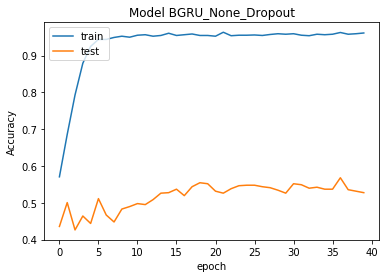

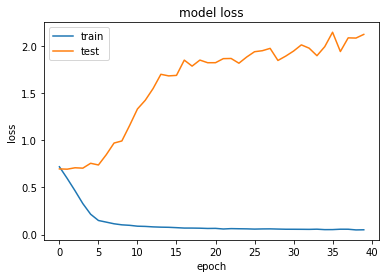

In [26]:
# summarize history for accuracy
plt.plot(history_bidir_none_dropou.history['acc'])
plt.plot(history_bidir_none_dropou.history['val_acc'])
plt.title('Model BGRU_None_Dropout')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bidir_none_dropou.history['loss'])
plt.plot(history_bidir_none_dropou.history['val_loss'])
plt.title('Model BGRU_None_Dropout loss measure')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

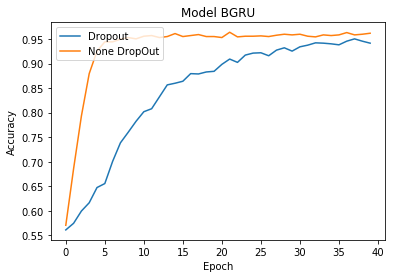

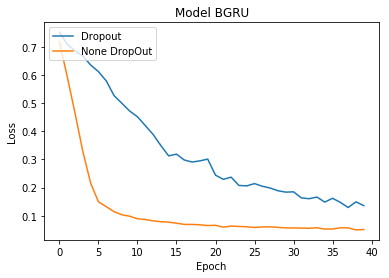

In [31]:
# summarize history for accuracy
plt.plot(history_bidir_atom.history['acc'])
plt.plot(history_bidir_none_dropou.history['acc'])
plt.title('Model BGRU')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Dropout', 'None DropOut'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history_bidir_atom.history['loss'])
plt.plot(history_bidir_none_dropou.history['loss'])
plt.title('Model BGRU')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Dropout', 'None DropOut'], loc='upper left')
plt.show()